<a href="https://colab.research.google.com/github/rgilyard/predict-student-outcomes/blob/main/model_training_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Model for Early Prediction of Student Failure

## Set the dataset size you would like to run
Please only uncomment one.<br>
**demo_sample_1000**: 1000 instances. This may take around -- minutes and may require -- GB of RAM to train<br>
**subset_10000**: 10000 instances. This may take around -- minutes and may require -- GB of RAM to train<br>
**complete_32593**: 32593 instances. This may take around 7.25 and may require 43GB+ of RAM to train (I trained it in Google Colab+ with 51GB of RAM)<br><br>

These training times do not include the run time of the rest of the notebook

In [1]:
# dataset = 'demo_sample_1000'
# dataset = 'subset_10000'
dataset = 'complete_32593'

### Set to true if you want to train a new model
Rather than just view the results from a trained model.<br>
Note that using the complete  dataset may take 7.25 hours to train (this does not include the runtime for the rest of the notebook)

In [2]:
# Train new model? otherwise load pre trained model
train_model = False

## Check the environment
### Set up environment


In [3]:
import sys
import os

In [4]:
# Function to check if the notebook is being run in google colab
def in_colab():
  # Check if 'google.colab' is in the list of modules
  return 'google.colab' in sys.modules

In [5]:
# Function to set up paths for google colab
def find_project_dir(base_name='COMP 542 Group Project'):
    # Start from the current directory (which will be '/content/' in Colab)
    for root, dirs, files in os.walk('/content'):
        if base_name in dirs:
            return os.path.join(root, base_name)
    raise FileNotFoundError(f'Could not find directory {base_name}')

In [6]:
if in_colab():
  print("Running in Google Colab")
  # Connect to google colab storage
  from google.colab import drive
  drive.mount('/content/drive')
  # Find data directory and set as base path
  project_dir = find_project_dir()
  print(f"Project directory: {project_dir}")
else:
  print("Not running in Google Colab")
  # Code for Jupyter Notebook or other environments
  # Set a different base path or use local file paths

Running in Google Colab
Mounted at /content/drive
Project directory: /content/drive/MyDrive/COMP 542 Group Project


## Libraries

In [7]:
import pandas as pd
import numpy as np
import time
import joblib
from datetime import datetime

## Load data

In [8]:
## Create path to dataset and model
DATA_PATH = f'/content/drive/MyDrive/COMP 542 Group Project/engineered_student_info_{dataset}.csv'
MODEL_PATH = f'/content/drive/MyDrive/COMP 542 Group Project/gaussian_test_2023-11-21_00-01-08.joblib'
df = pd.read_csv(DATA_PATH)

In [9]:
df = df[:20000]
print(df.head())

  gender                region      highest_education imd_band age_band  \
0      M   East Anglian Region       HE Qualification  90-100%     55<=   
1      F              Scotland       HE Qualification   20-30%    35-55   
2      F  North Western Region  A Level or Equivalent   30-40%    35-55   
3      F     South East Region  A Level or Equivalent   50-60%    35-55   
4      F  West Midlands Region     Lower Than A Level   50-60%     0-35   

   num_of_prev_attempts  studied_credits disability final_result  \
0                     0              240          N         Pass   
1                     0               60          N         Pass   
2                     0               60          Y    Withdrawn   
3                     0               60          N         Pass   
4                     0               60          N         Pass   

  course_instance  early_assessment_avg  avg_days_early_submission  \
0       AAA_2013J             82.666667                        1.0   


## Preprocessing

### Combine fail/withdraw and pass/distinction for binary prediction

In [10]:
df['fail'] = df['final_result'].apply(lambda x: 1 if x in ['Fail', 'Withdrawn'] else 0)

### Split into training and test sets

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(['final_result', 'fail'], axis=1)  # Dropping the target columns
y = df['fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9001)

### Missing values

In [12]:
# Check how many values are missing
print(X_train.isnull().sum())

gender                         0
region                         0
highest_education              0
imd_band                     504
age_band                       0
num_of_prev_attempts           0
studied_credits                0
disability                     0
course_instance                0
early_assessment_avg           0
avg_days_early_submission      0
distinct_days                  0
avg_clicks_per_day             0
total_clicks                   0
date_registration             26
date_unregistration            0
dtype: int64


In [13]:
# Since there are not too many missing values, we can take the mode for imd_band
X_train['imd_band'].fillna(X_train['imd_band'].mode()[0], inplace=True)
X_test['imd_band'].fillna(X_test['imd_band'].mode()[0], inplace=True)

X_train['date_registration'].fillna(X_train['date_registration'].mean(), inplace=True)
X_test['date_registration'].fillna(X_test['date_registration'].mean(), inplace=True)

# # Mean imputation for early assessment grade average
# X_train['early_assessment_avg'].fillna(X_train['early_assessment_avg'].mean(), inplace=True)
# X_test['early_assessment_avg'].fillna(X_test['early_assessment_avg'].mean(), inplace=True)

print(X_train.isnull().sum())

gender                       0
region                       0
highest_education            0
imd_band                     0
age_band                     0
num_of_prev_attempts         0
studied_credits              0
disability                   0
course_instance              0
early_assessment_avg         0
avg_days_early_submission    0
distinct_days                0
avg_clicks_per_day           0
total_clicks                 0
date_registration            0
date_unregistration          0
dtype: int64


### Label encode binary features

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [15]:
# Lists for each type of feature to encode
# List of binary columns
binary = ['gender', 'disability']

# List of categorical columns
categorical = ['course_instance', 'region']

# List of ordinal columns
ordinal = {'highest_education': [\
              'No Formal quals', \
              'Lower Than A Level', \
              'A Level or Equivalent', \
              'HE Qualification', \
              'Post Graduate Qualification'], \
           'imd_band': [\
              '0-10%', \
              '10-20', \
              '20-30%', \
              '30-40%', \
              '40-50%', \
              '50-60%', \
              '60-70%', \
              '70-80%', \
              '80-90%', \
              '90-100%'], \
           'age_band': [\
              '0-35', \
              '35-55', \
              '55<=']}

In [16]:
# Label encode binary features
label_encoder = LabelEncoder()

for feature in binary:
  label_encoder.fit(X_train[feature])
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [17]:
# Label encode ordinal features in order
for feature, order in ordinal.items():
  label_encoder = LabelEncoder()
  label_encoder.fit(order)
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [18]:
# One hot encode categorical features
X_train = pd.get_dummies(X_train, columns=categorical)
X_test = pd.get_dummies(X_test, columns=categorical)

In [19]:
# Because there a some categories with very few instances,
# make sure all the features are in both sets
# Add the missing columns filled with zeros
for col in X_train.columns:
  if col not in X_test.columns:
    X_test[col] = 0

# Reorder test columns to match the order in training set
X_test = X_test[X_train.columns]
feature_names = X_train.columns[X_train.columns != 'fail'].tolist()
X_train.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,early_assessment_avg,avg_days_early_submission,distinct_days,...,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region
7045,0,0,2,0,2,120,0,45.000000,0.000000,6,...,0,0,0,0,0,0,0,0,0,0
3902,0,1,5,1,0,120,0,75.416667,0.333333,14,...,0,0,0,0,0,0,1,0,0,0
18737,0,2,6,0,0,60,1,67.200000,0.666667,54,...,0,0,0,0,0,0,0,0,0,0
7272,0,1,5,0,0,120,0,0.000000,71.000000,3,...,0,0,1,0,0,0,0,0,0,0
12331,1,0,8,0,0,30,0,0.000000,71.000000,1,...,0,0,0,0,0,0,0,0,0,0


# Normalize data

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_prepared = scaler.fit_transform(X_train)
X_test_prepared = scaler.transform(X_test)

## Train Gaussian Process Model

In [21]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [22]:
# Initialize the Kernel and the Classifiers
# kernel = 1.0 * RBF(1.0)  # RBF kernel with length scale of 1.0
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e+6))
gp_classifier = GaussianProcessClassifier(kernel=kernel)

In [23]:
if train_model:
  # Time model training duration
  start_time = time.time()
  start_datetime = datetime.fromtimestamp(start_time)
  print("Start time:", start_datetime.strftime('%Y-%m-%d %H:%M:%S'))
  # Train model
  gp_classifier = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)
  gp_classifier.fit(X_train_prepared, y_train)
  # Record model train duration end time
  end_time = time.time()

In [24]:
if train_model:
  # Save model
  # Get current date and time
  now = datetime.now()
  # Format datetime object to string
  formatted_date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
  # Append datetime to file name
  model_name_with_datetime = f'/content/drive/MyDrive/COMP 542 Group Project/gaussian_test_{formatted_date_time}.joblib'
  joblib.dump(gp_classifier, model_name_with_datetime)
else:
  gp_classifier = joblib.load(MODEL_PATH)

In [25]:
if train_model:
  elapsed_time = end_time - start_time
  print(f"Time taken for training: {elapsed_time:.2f} seconds")

## Evaluate Model

In [26]:
# Evaluate Model
score = gp_classifier.score(X_test_prepared, y_test)
print("Model Accuracy: {:.2f}%".format(score * 100))

Model Accuracy: 82.47%


In [27]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Predict labels
y_pred = gp_classifier.predict(X_test_prepared)

# Calculate precision, recall, and accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")


Precision: 0.8840361445783133
Recall: 0.789332138054684
Accuracy: 0.82475


In [28]:
# Make Predictions
y_prob = gp_classifier.predict_proba(X_test_prepared)[:, 1]  # Probabilities of the positive class

### ROC curve

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [30]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)

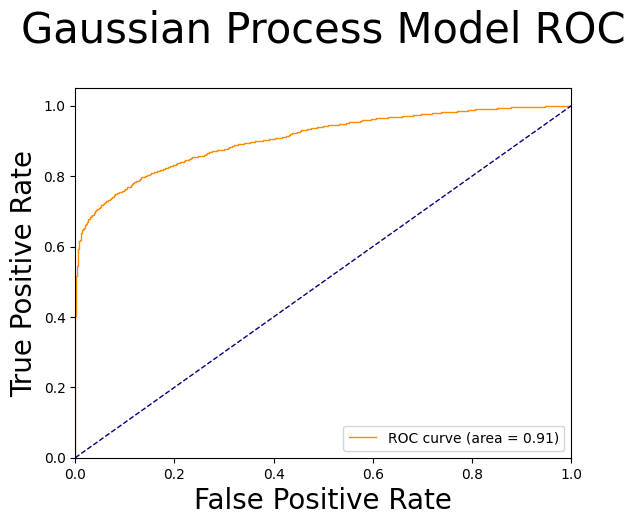

In [31]:
# Plot figure
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Gaussian Process Model ROC', fontsize=30, y=1.1)
plt.legend(loc='lower right')
plt.show()

## Feature Importance

In [32]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
result = permutation_importance(gp_classifier, X_test_prepared, y_test, n_repeats=10, random_state=0)

# Get feature importances and their indices
importances = result.importances_mean
sorted_idx = importances.argsort()

In [33]:
print(importances)

[-4.50000e-04  5.00000e-03  1.17500e-03  5.75000e-04  4.25000e-03
 -7.75000e-04 -1.22500e-03  1.90125e-01  3.75000e-03  1.82250e-02
  2.55000e-03  6.50000e-04  1.20000e-03  6.60000e-02  2.10000e-03
  1.82500e-03  4.75000e-04  6.75000e-04  5.00000e-05  4.72500e-03
 -3.75000e-04 -1.00000e-04  3.32500e-03  1.37500e-03  1.42500e-03
  4.92500e-03 -2.50000e-05  2.00000e-04 -4.25000e-04 -2.50000e-05
 -7.50000e-04 -5.00000e-05  5.00000e-05 -7.00000e-04 -5.00000e-04
 -6.25000e-04 -1.55000e-03  2.50000e-04  1.50000e-04  3.25000e-04]


In [34]:
sorted_idx = importances.argsort()
print(sorted_idx)

[36  6  5 30 33 35 34  0 28 20 21 31 29 26 18 32 38 27 37 39 16  3 11 17
  2 12 23 24 15 14 10 22  8  4 19 25  1  9 13  7]


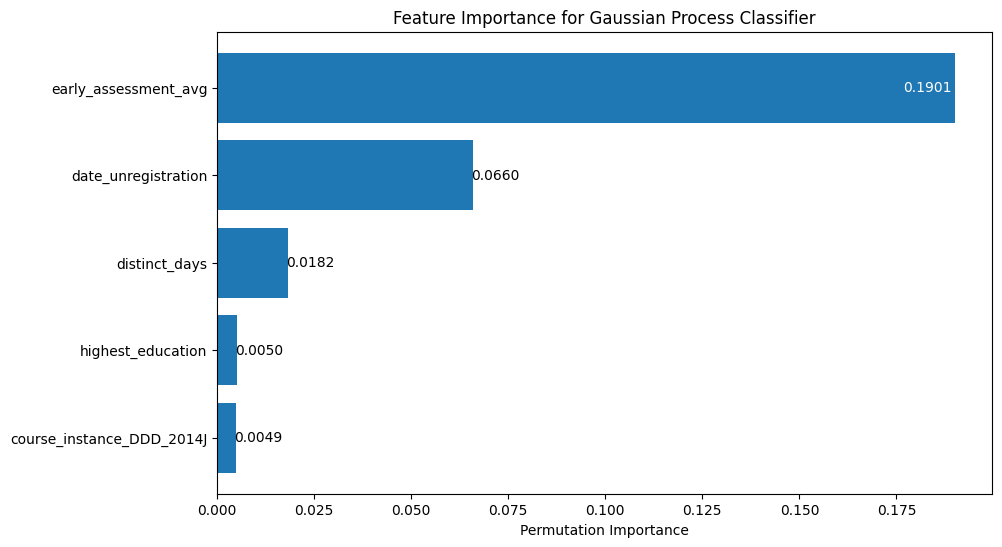

In [35]:
threshold = 0.1  # set a threshold to decide text placement

# Number of top features to display
top_n = 5

# Plotting code, but restricted to 'top_n' most important features
plt.figure(figsize=(10, 6))
bars = plt.barh(range(top_n), importances[sorted_idx][-top_n:])

# Add annotations
for bar in bars:
    bar_width = bar.get_width()
    if bar_width > threshold:
        text_x_position = bar_width - 0.001
        text_color = 'white'
    else:
        text_x_position = bar_width + 0.012
        text_color = 'black'

    plt.text(text_x_position,  # x position
             bar.get_y() + bar.get_height() / 2,  # y position
             f'{bar_width:.4f}',  # text
             va='center',
             ha='right',
             color=text_color)

plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx[-top_n:]])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance for Gaussian Process Classifier')
plt.show()

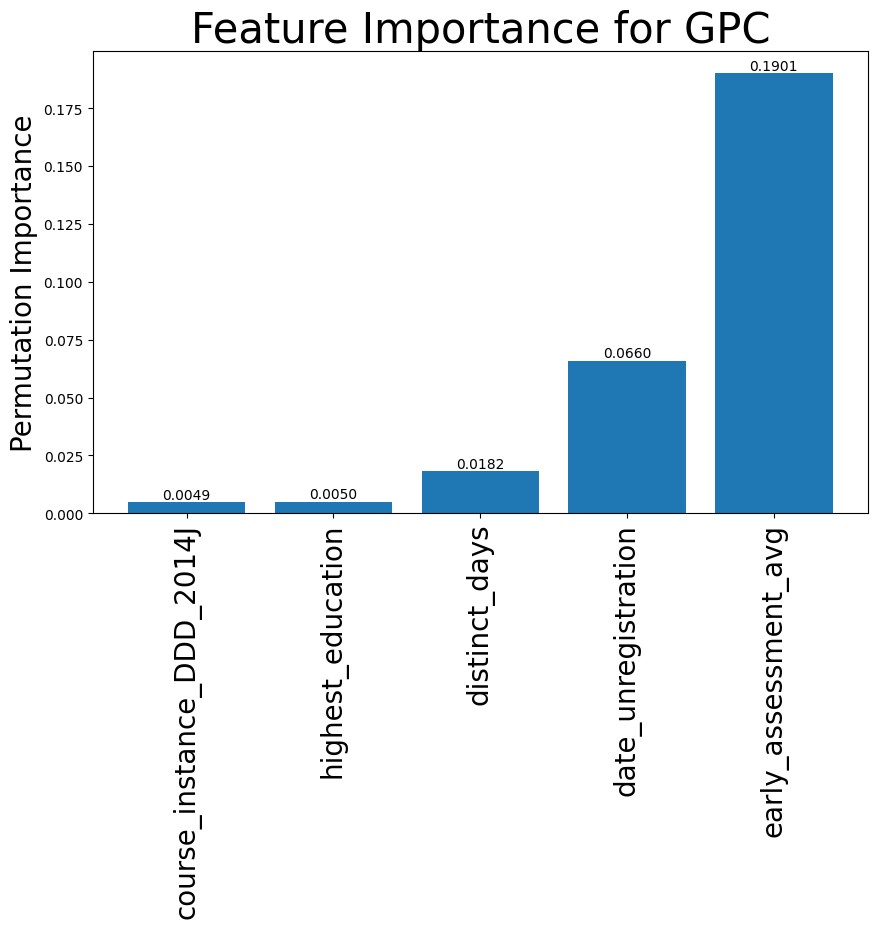

In [36]:
# Same but vertical
plt.figure(figsize=(10, 6))
bars = plt.bar(range(top_n), importances[sorted_idx][-top_n:])

# Add annotations
for bar in bars:
    bar_height = bar.get_height()
    text_y_position = bar.get_y() + bar_height / 2

    plt.text(bar.get_x() + bar.get_width() / 2,  # x position
             bar_height,  # y position
             f'{bar_height:.4f}',  # text
             va='bottom',
             ha='center')

# plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx[-top_n:]], rotation=45, fontsize=20, x=.5)
plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx[-top_n:]], rotation=90, fontsize=20)

plt.ylabel('Permutation Importance', fontsize=20)
plt.title('Feature Importance for GPC', fontsize=30)
plt.show()

## Generate Radial Basis Similarity Heatmap

In [37]:
from sklearn.gaussian_process.kernels import RBF

In [38]:
print(X_train.columns)

Index(['gender', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'early_assessment_avg', 'avg_days_early_submission', 'distinct_days',
       'avg_clicks_per_day', 'total_clicks', 'date_registration',
       'date_unregistration', 'course_instance_AAA_2013J',
       'course_instance_AAA_2014J', 'course_instance_BBB_2013B',
       'course_instance_BBB_2013J', 'course_instance_BBB_2014B',
       'course_instance_BBB_2014J', 'course_instance_CCC_2014B',
       'course_instance_CCC_2014J', 'course_instance_DDD_2013B',
       'course_instance_DDD_2013J', 'course_instance_DDD_2014B',
       'course_instance_DDD_2014J', 'course_instance_EEE_2013J',
       'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West R

In [39]:
# Select a subset of data for better visualization and computational efficiency
subset_idx = np.random.choice(X_train.index.values, 150, replace=False)
# print(type(subset_idx))
# print(subset_idx.max())
# print(subset_idx.min())
# print(X_train.shape)
X_subset = X_train.loc[subset_idx][['studied_credits', 'early_assessment_avg']]
X_subset = X_subset.to_numpy()

In [40]:
# Create the RBF kernel (you can replace it with the kernel you used)
kernel = gp_classifier.kernel_

In [41]:
# Compute the similarity (covariance) matrix
K = kernel(X_subset)

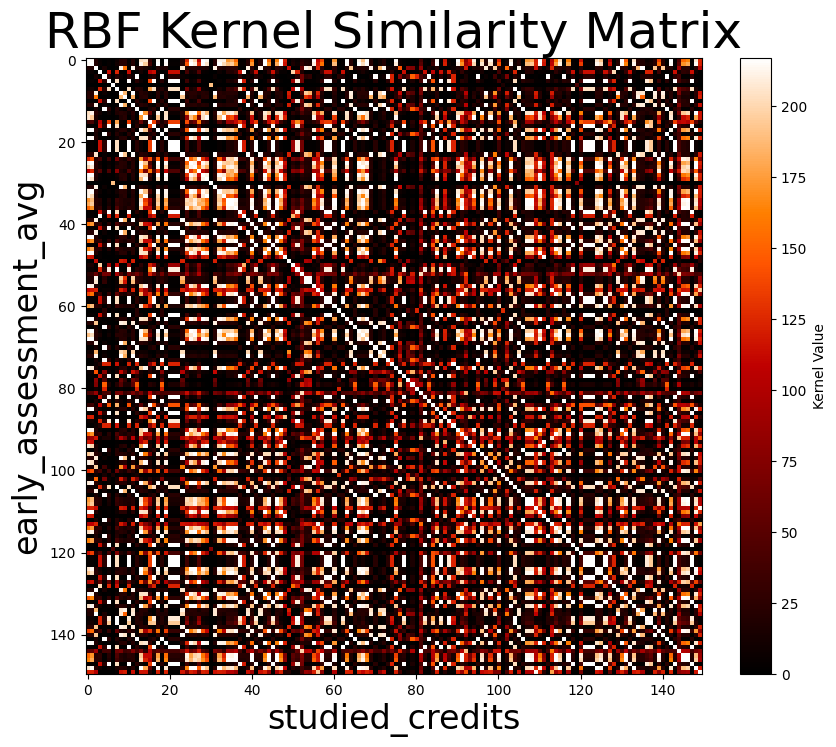

In [42]:
# Plot the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(K, interpolation='nearest', cmap='gist_heat', origin='upper')
plt.colorbar(label='Kernel Value')
plt.title('RBF Kernel Similarity Matrix', fontsize=36)
plt.xlabel('studied_credits', fontsize=24)
plt.ylabel('early_assessment_avg', fontsize=24)
plt.show()